In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import pandas as pd
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE = [224,224]

train_path = '/content/drive/MyDrive/Combat dataset 2/Train'
valid_path = '/content/drive/MyDrive/Combat dataset 2/Test'

In [ ]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(train_path)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset="validation",
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    subset="training",
    shuffle=True,
    target_size=IMAGE_SHAPE)


Found 160 images belonging to 4 classes.
Found 640 images belonging to 4 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 4))

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Army_Truck': 0, 'Civilian_Car': 1, 'Human': 2, 'MEADS': 3}


In [ ]:
  model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/100
20/20 [==============================] - 229s 10s/step - loss: 1.2520 - acc: 0.4437 - val_loss: 0.7638 - val_acc: 0.7500
Epoch 2/100
20/20 [==============================] - 2s 111ms/step - loss: 0.7501 - acc: 0.7078 - val_loss: 0.5750 - val_acc: 0.7812
Epoch 3/100
20/20 [==============================] - 2s 110ms/step - loss: 0.6033 - acc: 0.7578 - val_loss: 0.4696 - val_acc: 0.7812
Epoch 4/100
20/20 [==============================] - 2s 110ms/step - loss: 0.5162 - acc: 0.7906 - val_loss: 0.4533 - val_acc: 0.7875
Epoch 5/100
20/20 [==============================] - 2s 110ms/step - loss: 0.4398 - acc: 0.8188 - val_loss: 0.4502 - val_acc: 0.7812
Epoch 6/100
20/20 [==============================] - 2s 109ms/step - loss: 0.3850 - acc: 0.8578 - val_loss: 0.4305 - val_acc: 0.8188
Epoch 7/100
20/20 [==============================] - 2s 107ms/step - loss: 0.3771 - acc: 0.8547 - val_loss: 0.4069 - val_acc: 0.8250
Epoch 8/100
20/20 [==============================] - 2s 111ms/step - 

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

5/5 [==============================] - 0s 83ms/step - loss: 0.4880 - acc: 0.8562
Final loss: 0.49
Final accuracy: 85.62%


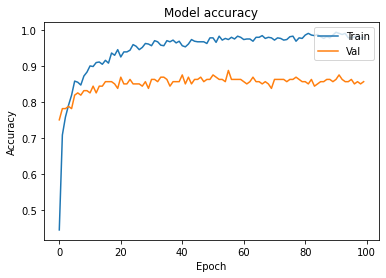

In [ ]:
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper right')
plt.show()

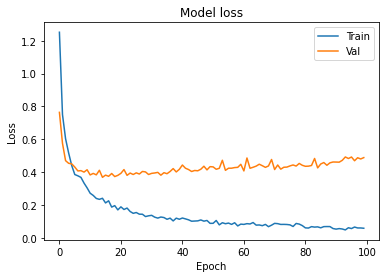

In [ ]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper right')
plt.show()

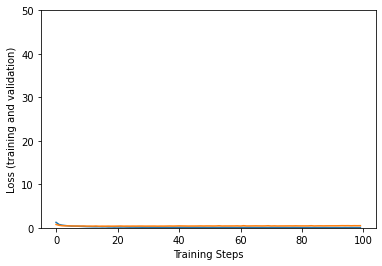

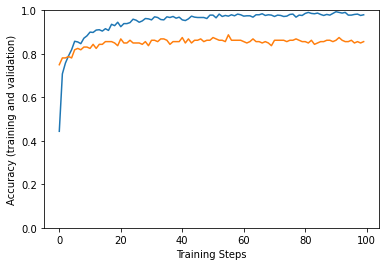

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Army_Truck' 'Civilian_Car' 'Human' 'Meads']


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 4)


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Civilian_Car' 'Civilian_Car' 'Human' 'Civilian_Car' 'Meads' 'Human'
 'Army_Truck' 'Human' 'Army_Truck' 'Human' 'Civilian_Car' 'Meads'
 'Civilian_Car' 'Meads' 'Human' 'Civilian_Car' 'Human' 'Civilian_Car'
 'Army_Truck' 'Human' 'Human' 'Human' 'Human' 'Army_Truck' 'Human'
 'Army_Truck' 'Civilian_Car' 'Civilian_Car' 'Civilian_Car' 'Civilian_Car'
 'Army_Truck' 'Meads']


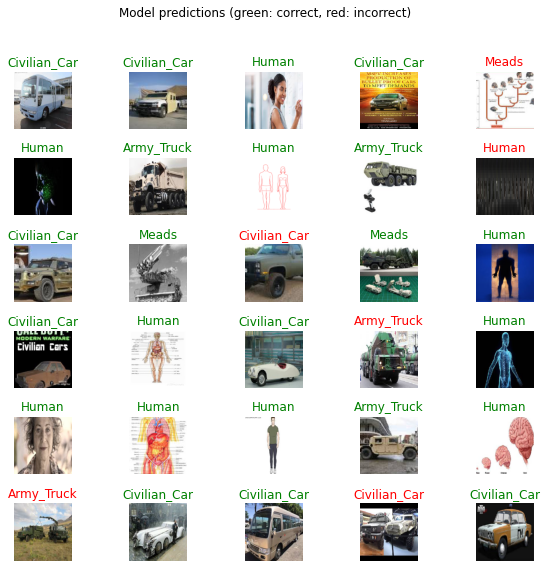

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving IMG_20161220_095629_HDR.jpg to IMG_20161220_095629_HDR.jpg


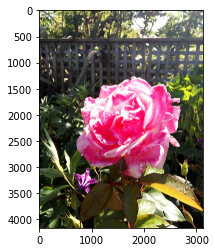

In [ ]:
new_image = plt.imread('IMG_20161220_095629_HDR.jpg')
img = plt.imshow(new_image)

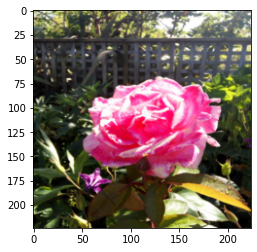

In [ ]:
from skimage.transform import resize
resized_image = resize(new_image, (224,224,3))
img = plt.imshow(resized_image)

In [ ]:
predictions = model.predict(np.array([resized_image]))
predictions

array([[2.8794691e-05, 2.8554970e-02, 9.4223118e-01, 2.9184988e-02]],
      dtype=float32)

In [ ]:
list_index = [0,1,2,3]
x = predictions

for i in range(4):
  for j in range(4):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

      print(list_index)


[1, 0, 2, 3]
[2, 0, 1, 3]
[2, 1, 0, 3]
[2, 3, 0, 1]
[2, 3, 1, 0]


In [ ]:
for i in range(1):
  print(dataset_labels[list_index[i]])


Human
